# Introduciton

This project aims to develop a neural network for binary classification to identify cancerous tissue in pathology scan images. The dataset, sourced from a Kaggle competition, comprises 220,025 labeled training images indicating the presence (1) or absence (0) of cancerous tissue, with cancerous defined as any image pixel containing tumorous tissue. An additional 57,458 unlabeled test images are provided for evaluation. Test performance will be assessed by submitting predictions to the Kaggle competition, as test labels are unavailable. The objective is to train a neural network to accurately predict the labels of the test set, thereby effectively identifying cancerous tissue in pathology images.
The data source: https://www.kaggle.com/competitions/histopathologic-cancer-detection/

In [65]:
import numpy as np
import pandas as pd
import os
import shutil
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import tensorflow as tf
import seaborn as sns
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout, BatchNormalization
from tensorflow.keras.utils import plot_model
import json


# Exploratory Data Analysis

In [2]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 13595644578616725445
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 6917455872
locality {
  bus_id: 1
  links {
  }
}
incarnation: 13132796485322515231
physical_device_desc: "device: 0, name: NVIDIA GeForce GTX 1080, pci bus id: 0000:01:00.0, compute capability: 6.1"
xla_global_id: 416903419
]


Generate file name by giving id

In [3]:
def generate_file_names(id):
    return f"./histopathologic-cancer-detection/train/{id}.tif"

Loads the train_labels.csv file into a DataFrame named train_df. Then, it adds a new column called "filepath" by applying a lambda function to concatenate the directory path with the image ID and the ".tif" extension. Finally, it prints the head of the DataFrame to confirm the structure, including the newly added "filepath" column.

In [4]:
train_df = pd.read_csv("./histopathologic-cancer-detection/train_labels.csv")
train_df["label"] = train_df["label"].astype(str)
print(train_df)
print(train_df.describe())
train_df["filepath"] = train_df["id"].apply(generate_file_names)

train_df.head()

                                              id label
0       f38a6374c348f90b587e046aac6079959adf3835     0
1       c18f2d887b7ae4f6742ee445113fa1aef383ed77     1
2       755db6279dae599ebb4d39a9123cce439965282d     0
3       bc3f0c64fb968ff4a8bd33af6971ecae77c75e08     0
4       068aba587a4950175d04c680d38943fd488d6a9d     0
...                                          ...   ...
220020  53e9aa9d46e720bf3c6a7528d1fca3ba6e2e49f6     0
220021  d4b854fe38b07fe2831ad73892b3cec877689576     1
220022  3d046cead1a2a5cbe00b2b4847cfb7ba7cf5fe75     0
220023  f129691c13433f66e1e0671ff1fe80944816f5a2     0
220024  a81f84895ddcd522302ddf34be02eb1b3e5af1cb     1

[220025 rows x 2 columns]
                                              id   label
count                                     220025  220025
unique                                    220025       2
top     f38a6374c348f90b587e046aac6079959adf3835       0
freq                                           1  130908


id label  \
0  f38a6374c348f90b587e046aac6079959adf3835     0   
1  c18f2d887b7ae4f6742ee445113fa1aef383ed77     1   
2  755db6279dae599ebb4d39a9123cce439965282d     0   
3  bc3f0c64fb968ff4a8bd33af6971ecae77c75e08     0   
4  068aba587a4950175d04c680d38943fd488d6a9d     0   

                                            filepath  
0  ./histopathologic-cancer-detection/train/f38a6...  
1  ./histopathologic-cancer-detection/train/c18f2...  
2  ./histopathologic-cancer-detection/train/755db...  
3  ./histopathologic-cancer-detection/train/bc3f0...  
4  ./histopathologic-cancer-detection/train/068ab...

220,025 labeled training photos are available to us, with each label denoting the presence (1) or absence (0) of cancerous tissue.

In [5]:
img = mpimg.imread(train_df["filepath"][0])
img.shape

(96, 96, 3)

The image loaded from the specified file path has dimensions of 96 pixels in height, 96 pixels in width, and consists of three color channels (RGB). This signifies a standard RGB image with each pixel represented by a triplet of values corresponding to its intensity in the Red, Green, and Blue channels. The intensity values typically range from 0 to 255 for each channel, defining the color composition of the image.

Let's look at the first ten images from the path. 

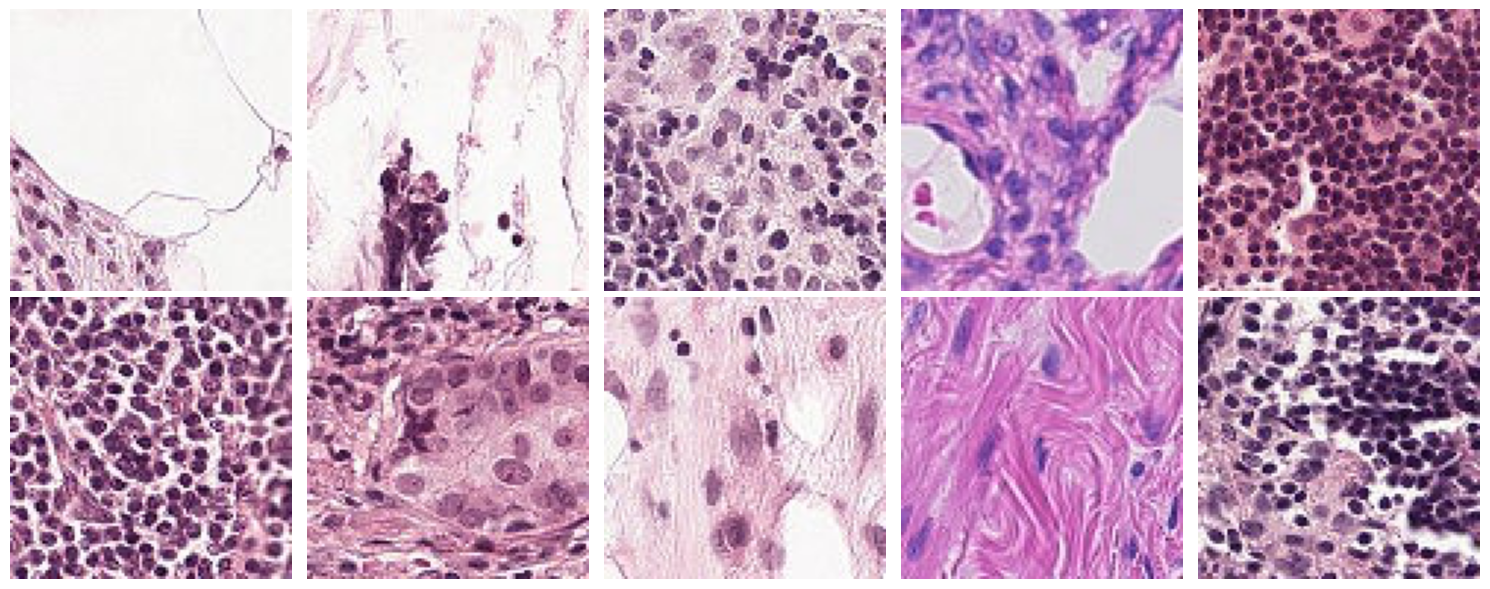

In [6]:
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
for i, ax in enumerate(axes.ravel()):
    # Open the image
    img = mpimg.imread(train_df["filepath"][i])
    
    # Display the image
    ax.imshow(img)
    ax.axis('off')

plt.tight_layout()
plt.show()

Examine the dataset's balance by displaying the proportion of the training dataset that is cancerous (1) and the proportion that is not (0).

label
0    59.496875
1    40.503125
Name: count, dtype: float64


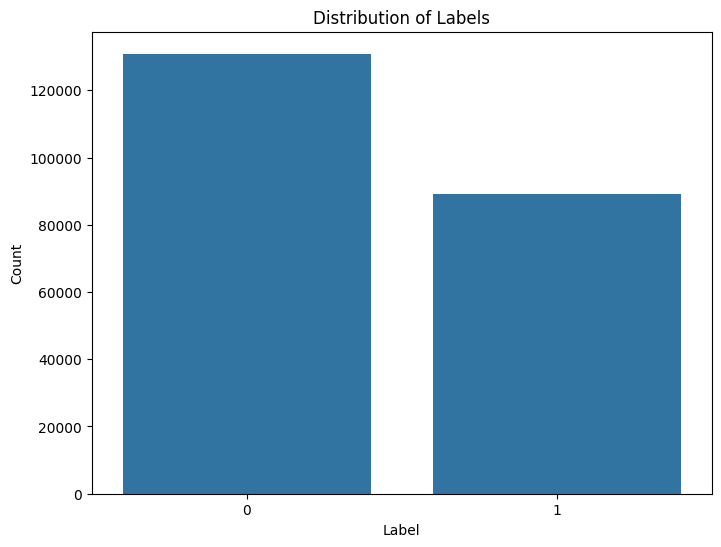

In [7]:
label_counts = train_df['label'].value_counts()

# Calculate the percentage of each label
label_percentages = label_counts / len(train_df) * 100

# Display the percentages
print(label_percentages)
plt.figure(figsize=(8, 6))
sns.countplot(x='label', data=train_df)
plt.title('Distribution of Labels')
plt.xlabel('Label')
plt.ylabel('Count')
plt.show()

The collection is composed of 60% non-cancerous samples and just 40% cancerous examples. Even though this is a little off, not sufficiently off to require any adjustments to balance the dataset—at least not on the initial pass.

# Show 10 pictures that are cancerous and 10 pictures that are not. 

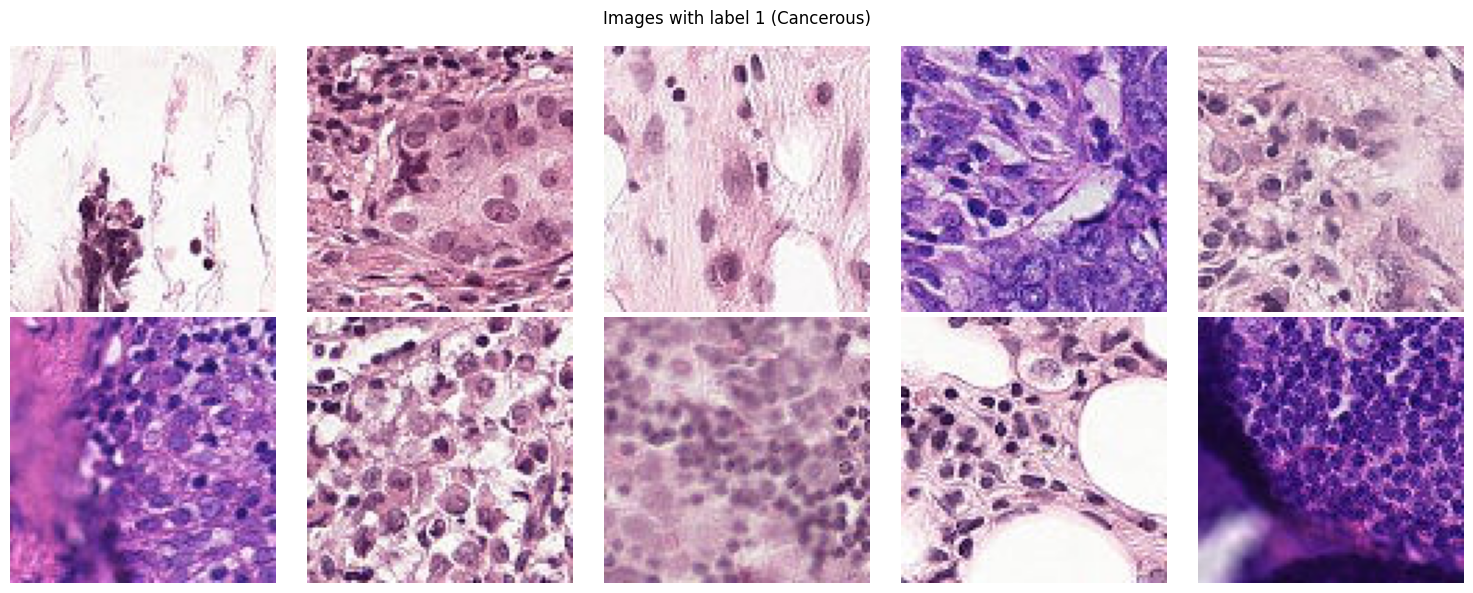

In [8]:
label_1_df = train_df[train_df['label'] == '1']
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
for i, ax in enumerate(axes.ravel()):
    # Check if there are still images to display
    if i < len(label_1_df):
        # Open the image
        img = mpimg.imread(label_1_df["filepath"].iloc[i])
        
        # Display the image
        ax.imshow(img)
        ax.axis('off')
    else:
        # Hide any empty subplot
        ax.axis('off')

plt.suptitle("Images with label 1 (Cancerous)")
plt.tight_layout()
plt.show()

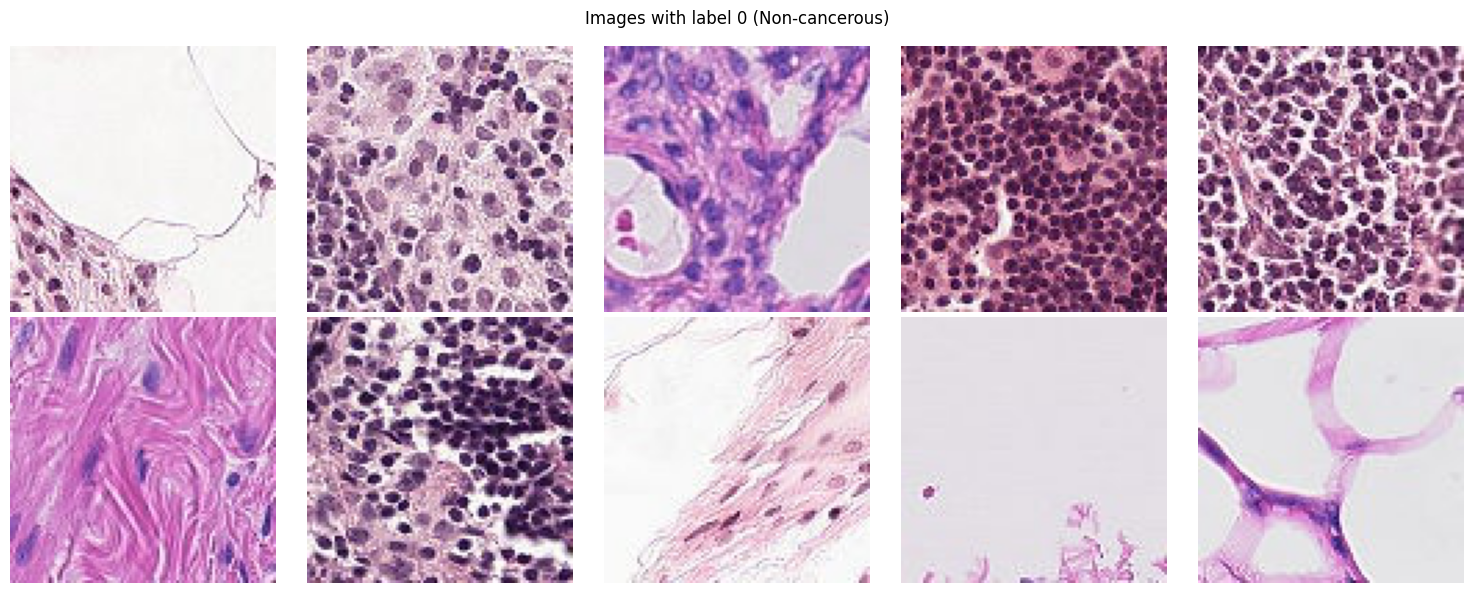

In [9]:
label_0_df = train_df[train_df['label'] == '0']
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
for i, ax in enumerate(axes.ravel()):
    # Check if there are still images to display
    if i < len(label_0_df):
        # Open the image
        img = mpimg.imread(label_0_df["filepath"].iloc[i])
        
        # Display the image
        ax.imshow(img)
        ax.axis('off')
    else:
        # Hide any empty subplot
        ax.axis('off')

plt.suptitle("Images with label 0 (Non-cancerous)")
plt.tight_layout()
plt.show()

Visually, the photos with and without cancer appear to have similar qualities. Both image sets are quite varied and include elements like large white blobs, black areas, and little clusters of purple cells. It is impossible to identify any visual cues that differentiate a malignant image from a non-cancerous one without the appropriate medical knowledge.

Since our dataset lacks missing values, outliers, and class imbalances, our data cleaning procedures are minimal. However, preprocessing steps such as normalization, resizing, and augmentation are essential for image data. We plan to normalize pixel values to [0, 1], resize images to a uniform size, and apply augmentation techniques to enhance model generalization. Our analysis will involve selecting appropriate machine learning or deep learning algorithms, splitting the dataset, training models, tuning hyperparameters, and evaluating performance metrics on validation sets. We aim to iterate this process to optimize model performance, ultimately testing the best-performing model on unseen test data for robustness in histopathologic cancer detection.


Based on EDA, we can proceed with building and evaluating machine learning models for histopathologic cancer detection.
This involves selecting appropriate algorithms, preprocessing image data, splitting the dataset, training models,
tuning hyperparameters, and evaluating model performance using metrics like accuracy, precision, recall, and F1-score.

# Model architecture 

First, let's use a package called "ImageDataGenerator." It will divide the data into an 80/20 train-validation ratio and rescale the images so that each pixel is between 0 and 1 before processing each image. 

In [10]:
datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

Once the train and validation generators are defined, the images will be read in according to the filepaths listed in the train_df, and their labels will be stored according on the labels found in that dataframe. There will be 16 photos in the batch.

In [11]:
train_generator = datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col="filepath",
    y_col="label",
    target_size=(96, 96),
    color_mode="rgb",
    batch_size=16,  # Set batch size to 16
    class_mode="binary",
    subset="training"
)

validation_generator = datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col="filepath",
    y_col="label",
    target_size=(96, 96),
    color_mode="rgb",
    batch_size=16,
    class_mode="binary",
    subset="validation"
)

Found 176020 validated image filenames belonging to 2 classes.
Found 44005 validated image filenames belonging to 2 classes.


We are now reading the sample_submission.csv file and exporting the predicted solution to a different csv file. 

In [12]:
test_path = "./histopathologic-cancer-detection/test"
test_ids = [filename[:-4] for filename in os.listdir(test_path)]
test_filepath = [os.path.join(test_path, filename) for filename in os.listdir(test_path)]
test_df = pd.DataFrame()
test_df["id"] = test_ids
test_df["filepath"] = test_filepath

test_generator = datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col="filepath",
    y_col=None,
    target_size=(96, 96),
    color_mode="rgb",
    batch_size=16,
    shuffle=False,
    class_mode=None
)

Found 57458 validated image filenames.


Next, specify a few neural network training functions. Determining these functions reduces the amount of common code greatly because several neural networks will be trained. 

The model training is carried out via the first function, train_model. It takes an untrained model and trains it using the training data; it also monitors the model's performance using validation data and employs early stopping to avoid overfitting. If after 10 epochs the validation loss has not decreased, this early stopping takes place. When the function finishes training, it saves the training history and dumps the trained model and the history to a file so that the model can be loaded again if needed. A model will provide a plot that visualizes the training and validation loss, accuracy, and AUC over the training epochs if plot is true after the model has been either loaded or trained. If run_test is true, it will run the second function make_output_csv, which processes the test data and outputs the results in an appropriate format to be submitted to the Kaggle competition for evaluation.

The epoch whose weights are preserved in the model after early halting is the one with the lowest validation loss, and this epoch's summary information is printed and returned at the end. . 

In [42]:
def train_model(model, train_generator, validation_generator, test_generator, folder_path, load_from_file, plot=True, run_test=True):
    np.random.seed(0)
    tf.random.set_seed(0)
    
    checkpoint_path = os.path.join(folder_path, "model.weights.h5")
    history_path = os.path.join(folder_path, "history.json")
    
    if load_from_file:
        print("Loading Model from File")
        model.load_weights(checkpoint_path)
        with open(history_path) as f:
            history = json.load(f)
    else:
        if os.path.exists(folder_path):
            shutil.rmtree(folder_path)
        os.makedirs(folder_path, exist_ok=True)
        
        checkpoint = ModelCheckpoint(checkpoint_path, save_weights_only=True, verbose=1, save_best_only=True)
        early_stopping = EarlyStopping(monitor="val_loss", patience=10, verbose=1)

        history = model.fit(train_generator,
                            validation_data=validation_generator,
                            epochs=100,
                            callbacks=[early_stopping, checkpoint]).history

        with open(history_path, "w+") as f:
            json.dump(history, f)
            
    if plot:
        plot_history(history)
        
    if run_test:
        make_output_csv(model, test_generator, folder_path)
        
    return get_best_metrics(history)

def plot_history(history):

    plt.figure(figsize=(15, 5))
    plt.subplot(1, 3, 1)
    plt.plot(np.arange(1, len(history["loss"]) + 1), history["loss"], label="train")
    plt.plot(np.arange(1, len(history["val_loss"]) + 1), history["val_loss"], label="validation")
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()

    plt.subplot(1, 3, 2)
    plt.plot(np.arange(1, len(history["accuracy"]) + 1), history["accuracy"], label="train")
    plt.plot(np.arange(1, len(history["val_accuracy"]) + 1), history["val_accuracy"], label="validation")
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend()

    plt.subplot(1, 3, 3)
    plt.plot(np.arange(1, len(history["auc"]) + 1), history["auc"], label="train")
    plt.plot(np.arange(1, len(history["val_auc"]) + 1), history["val_auc"], label="validation")
    plt.title('Model AUC')
    plt.ylabel('AUC')
    plt.xlabel('Epoch')
    plt.legend()

    plt.tight_layout()
    plt.show()

def make_output_csv(model, test_generator, folder_path):
    test_probs = model.predict(test_generator)
    test_labels = np.round(test_probs).astype(int).flatten()
    out_df = pd.DataFrame({"id": test_ids, "label": test_labels})
    out_df.to_csv(os.path.join(folder_path, "test_labels.csv"), index=False)

def get_best_metrics(history):
    i_min = np.argmin(history["val_loss"])
    best_epoch = i_min + 1
    best_loss = history['val_loss'][i_min]
    best_accuracy = history['val_accuracy'][i_min]
    best_auc = history['val_auc'][i_min]
    return best_epoch, best_loss, best_accuracy, best_auc


# Fully Connected

The first model that will be trained for this problem is a simple, fully connected neural network. It will have two hidden layer with 256 nodes and 128 nodes that uses a ReLU activation function and a single output node that uses a sigmoid activation function.

As this is a binary classification problem, binary cross entropy will be used as the loss function and the ADAM optimizer will be used. In addition to the loss, the metrics of accuracy and AUC will be monitored. All future models will also be compiled in the same way. 

In [43]:
f_c_model = Sequential()

# Specify the input shape using an Input(shape) object as the first layer in the model
f_c_model.add(Flatten(input_shape=(96, 96, 3)))  # Input shape of (96, 96, 3)

# Add Dense layers
f_c_model.add(Dense(256, activation='relu'))

f_c_model.add(Dense(128, activation='relu'))

# Output layer
f_c_model.add(Dense(1, activation='sigmoid'))  # Sigmoid activation for binary classification

# Compile the model
f_c_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', 'AUC'])

# Print model summary
f_c_model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_6 (Flatten)         (None, 27648)             0         
                                                                 
 dense_18 (Dense)            (None, 256)               7078144   
                                                                 
 dense_19 (Dense)            (None, 128)               32896     
                                                                 
 dense_20 (Dense)            (None, 1)                 129       
                                                                 
Total params: 7,111,169
Trainable params: 7,111,169
Non-trainable params: 0
_________________________________________________________________


Loading Model from File


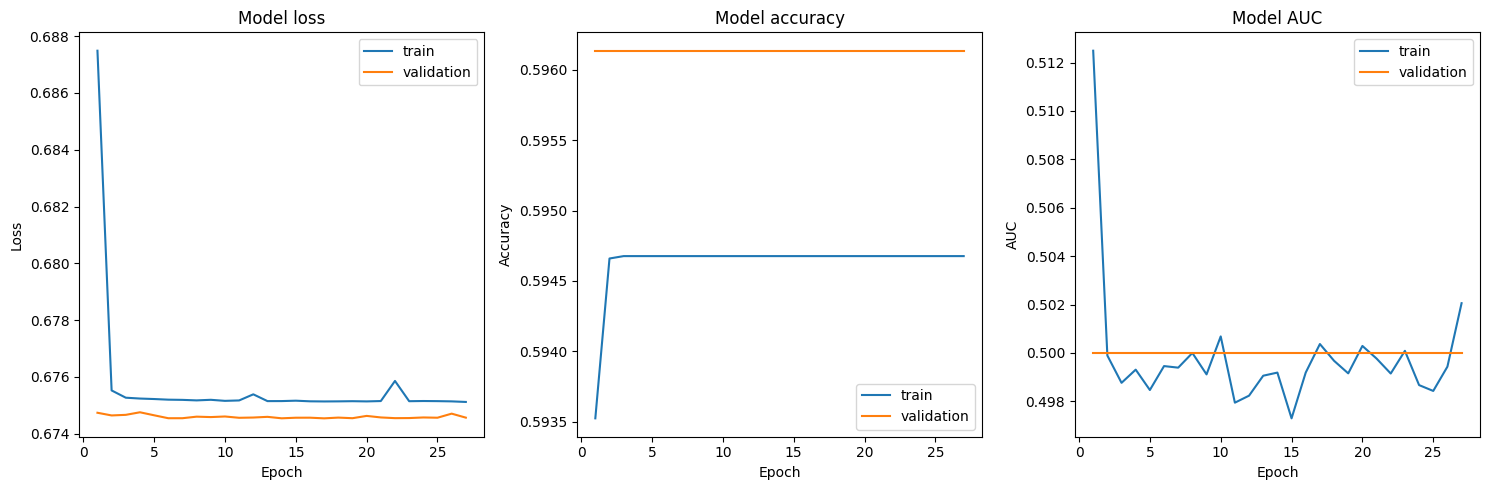

Best Epoch: 17
Best Model Loss: 0.6745419502258301
Best Model Accuracy: 0.5961368083953857
Best Model AUC: 0.5


In [44]:
f_c_train_res = train_model(f_c_model, train_generator, validation_generator, test_generator, "./f_c_model", load_from_file= True, run_test=False)
print(f"Best Epoch: {f_c_train_res[0]}")
print(f"Best Model Loss: {f_c_train_res[1]}")
print(f"Best Model Accuracy: {f_c_train_res[2]}")
print(f"Best Model AUC: {f_c_train_res[3]}")

The validation loss ceased getting better after epoch 17, when the optimization reached a validation accuracy of 59.6% and an AUC of 0.5. As a result, it was prematurely stopped after running for 27 epochs. The results is not really good at all because model accuaracy and auc aren;t changing after the the run. <br><br>
The validation accuracy of 0.596 is somewhat greater than the Kaggle test score of 0.5. This offers more evidence that the model was overfit at first and that its final performance in terms of generalizing to the test data was subpar. . 

To record the validation loss, accuracy, and AUC of each model in addition to the test AUC, a results_df will be constructed. This will facilitate further comparisons of all models.

In [48]:
results_df = pd.DataFrame(columns=["Model Name", "Validation Loss", "Validation Accuracy", "Validation AUC", "Test score"])
results_df.loc[len(results_df.index)] = ["Full Connected", f_c_train_res[1], f_c_train_res[2], f_c_train_res[3], 0.5]

# Convolutional

Convolutional neural networks make more sense as a neural network architecture than full connected ones as the objective is to identify specific features in these images that might suggest the presence of tumorous tissue. Convolutional neural networks are ideal for this purpose because they can recognize characteristics in a picture regardless of where they are located.

To start with try a simple convolutional neural network with two convolutional layers that each hav 32 3x3 and 64 3x3 convolutional convolutional kernels and use a ReLU activation function.After the two convolutional layer, we add a maxpooling layerr. Finally, the output of themmax pooling layer is flattened and fed into the samefull connectede architecture used before, wit  hidden layesr of 256 nodes and  128 nodes and a final single output node. 

In [46]:
conv_model = Sequential()
conv_model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(96, 96, 3)))
conv_model.add(Conv2D(64, (3, 3), activation='relu'))
conv_model.add(MaxPooling2D((2, 2)))
conv_model.add(Flatten())
conv_model.add(Dense(256, activation="relu"))
conv_model.add(Dense(128, activation="relu"))
conv_model.add(Dense(1, activation="sigmoid"))

conv_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy', 'AUC'])

conv_model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 94, 94, 32)        896       
                                                                 
 conv2d_3 (Conv2D)           (None, 92, 92, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 46, 46, 64)       0         
 2D)                                                             
                                                                 
 flatten_7 (Flatten)         (None, 135424)            0         
                                                                 
 dense_21 (Dense)            (None, 256)               34668800  
                                                                 
 dense_22 (Dense)            (None, 128)               32896     
                                                      

Loading Model from File


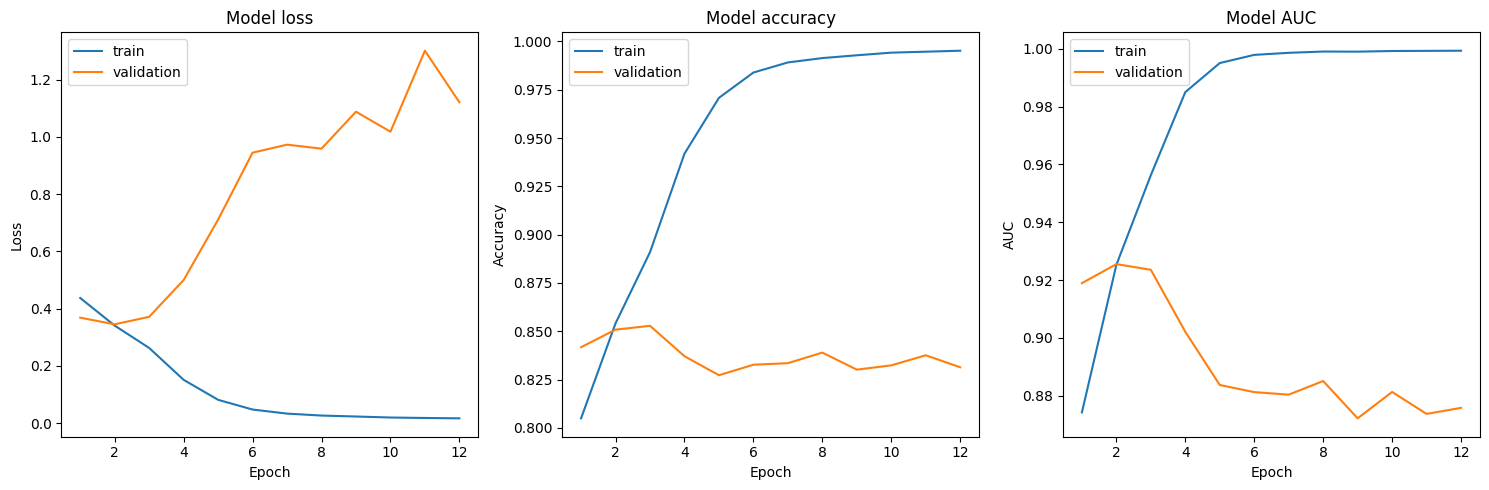

3592/3592 [==============================] - 48s 13ms/step
Best Epoch: 2
Best Model Loss: 0.3452622592449188
Best Model Accuracy: 0.8508351445198059
Best Model AUC: 0.9255308508872986


In [47]:
conv_train_res = train_model(conv_model, train_generator, validation_generator, test_generator, "./conv_model", load_from_file=True,run_test=False)
print(f"Best Epoch: {conv_train_res[0]}")
print(f"Best Model Loss: {conv_train_res[1]}")
print(f"Best Model Accuracy: {conv_train_res[2]}")
print(f"Best Model AUC: {conv_train_res[3]}")

After epoch 2, when it achieved an AUC of 0.925 and a validation accuracy of 85.1%, the validation loss ceased improving, and the optimization was prematurely stopped after running for 12 epochs. Very serious overfitting occurred early on and only grew worse with each epoch, as evidenced by the way the train, validation loss, and AUC begin to diverge from one another at epoch 2. >
The Kaggle test score of 0.8026 is somewhat lower than the validation accuracy of 0.851. This provides additional proof that the model was initially overfit and that its ability to generalize to the test data was not up to pace. 

In [49]:
results_df.loc[len(results_df.index)] = ["Convolutional", conv_train_res[1], conv_train_res[2], conv_train_res[3], 0.8026]

# Convolutional With Dropout

Add a dropout layer between the fully connected layer to provide some regularization in an attempt to address the early overfitting in the prior model. By building a more robust model with more significant weights, these drop out layers assist prevent overfitting by arbitrarily setting 50% of its inputs to zero. The architecture is the same as the preceding network, with the exception of the dropout layers.  

In [51]:
conv_dropout_model = Sequential()
conv_dropout_model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(96, 96, 3)))
conv_dropout_model.add(Conv2D(64, (3, 3), activation='relu'))
conv_dropout_model.add(MaxPooling2D((2, 2)))
conv_dropout_model.add(Flatten())
conv_dropout_model.add(Dense(256, activation="relu"))
conv_dropout_model.add(Dropout(0.5))
conv_dropout_model.add(Dense(128, activation="relu"))
conv_dropout_model.add(Dense(1, activation="sigmoid"))

conv_dropout_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy', 'AUC'])

conv_dropout_model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 94, 94, 32)        896       
                                                                 
 conv2d_5 (Conv2D)           (None, 92, 92, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 46, 46, 64)       0         
 2D)                                                             
                                                                 
 flatten_8 (Flatten)         (None, 135424)            0         
                                                                 
 dense_24 (Dense)            (None, 256)               34668800  
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                      

Loading Model from File


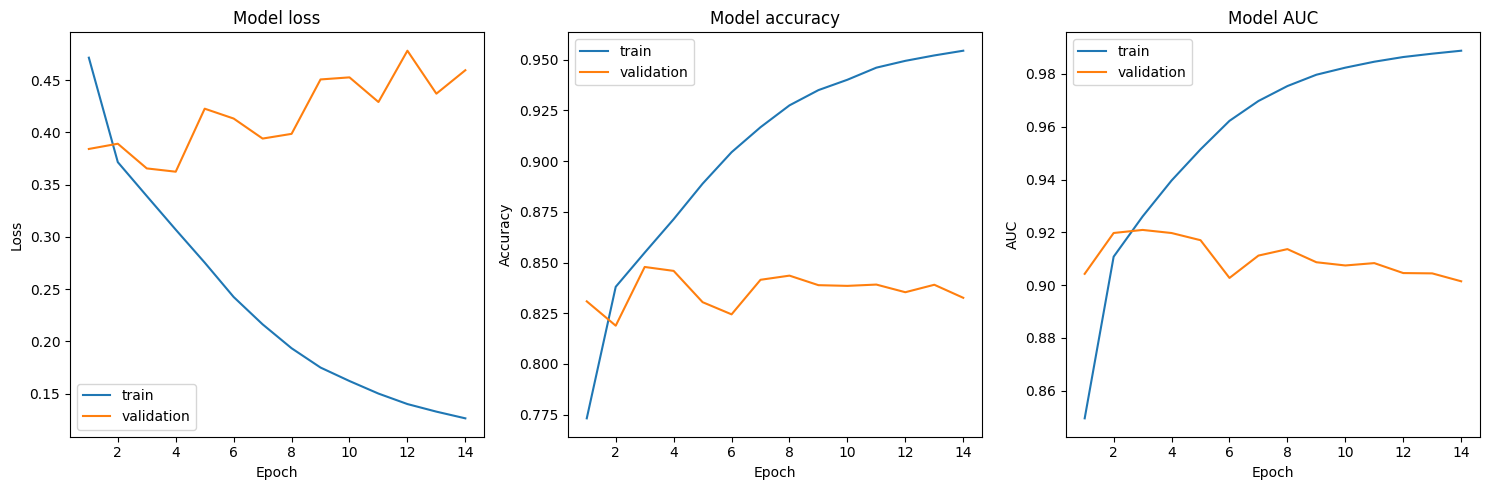

Best Epoch: 4
Best Model Loss: 0.36243563890457153
Best Model Accuracy: 0.8458811640739441
Best Model AUC: 0.9197126626968384


In [62]:
conv_dropout_train_res = train_model(conv_dropout_model, train_generator, validation_generator, test_generator, "./conv_dropout_model", load_from_file=True, run_test=False)
print(f"Best Epoch: {conv_dropout_train_res[0]}")
print(f"Best Model Loss: {conv_dropout_train_res[1]}")
print(f"Best Model Accuracy: {conv_dropout_train_res[2]}")
print(f"Best Model AUC: {conv_dropout_train_res[3]}")

After epoch 4, when it achieved an AUC of 0.92 and validation accuracy of 84.5%, the validation loss ceased improving, and the optimization was prematurely stopped after running for 14 epochs. The current model is not more efficient than the old one. <br> <br>
The Kaggle test score of 0.7978 indicates that overfitting is still present because it is somewhat lower than the validation AUC of 0.92.2.

In [53]:
results_df.loc[len(results_df.index)] = ["Convolutional Dropout", conv_dropout_train_res[1], conv_dropout_train_res[2], conv_dropout_train_res[3], 0.7978]

# Add Max pooling
Add MaxPooling layer after first convolution layer to reducing spatial dimensions and extracting important features from the input data.

In [84]:
conv_max_dropout_model = Sequential()
conv_max_dropout_model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(96, 96, 3)))
conv_max_dropout_model.add(MaxPooling2D((2, 2)))
conv_max_dropout_model.add(Conv2D(64, (3, 3), activation='relu'))
conv_max_dropout_model.add(MaxPooling2D((2, 2)))
conv_max_dropout_model.add(Flatten())
conv_max_dropout_model.add(Dense(256, activation="relu"))
conv_max_dropout_model.add(Dropout(0.5))
conv_max_dropout_model.add(Dense(128, activation="relu"))
conv_max_dropout_model.add(Dense(1, activation="sigmoid"))


conv_max_dropout_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy', 'AUC'])

conv_max_dropout_model.summary()

Model: "sequential_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_36 (Conv2D)          (None, 94, 94, 32)        896       
                                                                 
 max_pooling2d_20 (MaxPoolin  (None, 47, 47, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_37 (Conv2D)          (None, 45, 45, 64)        18496     
                                                                 
 max_pooling2d_21 (MaxPoolin  (None, 22, 22, 64)       0         
 g2D)                                                            
                                                                 
 flatten_20 (Flatten)        (None, 30976)             0         
                                                                 
 dense_60 (Dense)            (None, 256)             

Loading Model from File


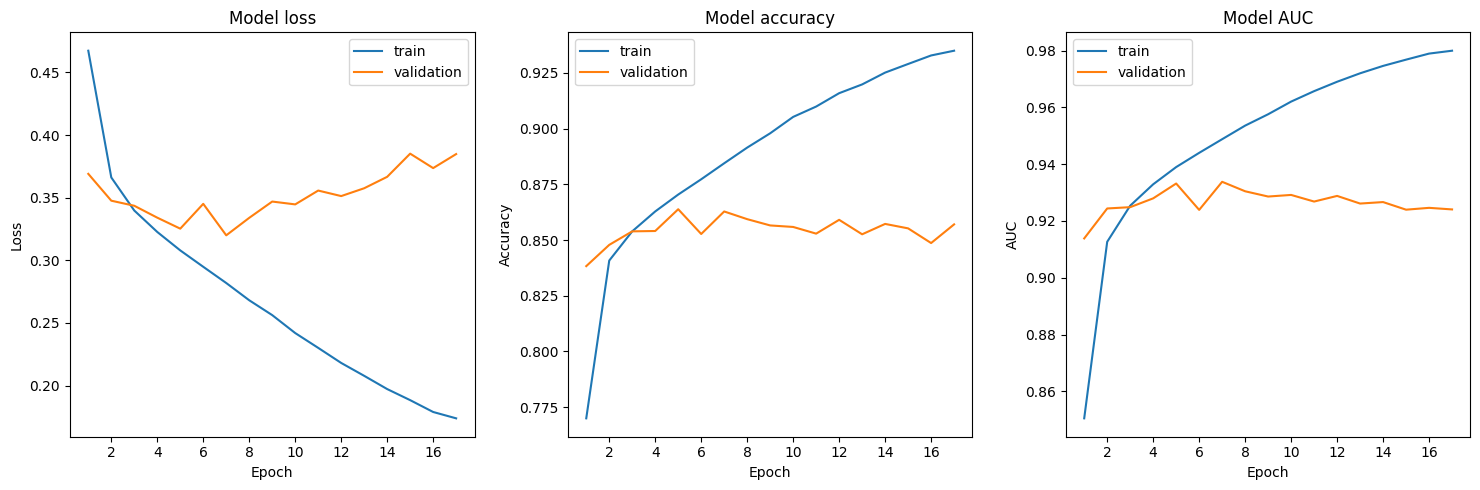

Best Epoch: 7
Best Model Loss: 0.31996238231658936
Best Model Accuracy: 0.8628110289573669
Best Model AUC: 0.933777391910553


In [89]:
conv_max_dropout_train_res = train_model(conv_max_dropout_model, train_generator, validation_generator, test_generator, "./conv_max_dropout_model", load_from_file=True, run_test=False)
print(f"Best Epoch: {conv_max_dropout_train_res[0]}")
print(f"Best Model Loss: {conv_max_dropout_train_res[1]}")
print(f"Best Model Accuracy: {conv_max_dropout_train_res[2]}")
print(f"Best Model AUC: {conv_max_dropout_train_res[3]}")

After epoch 7, when it achieved an AUC of 0.934 and validation accuracy of 86.2%, the validation loss ceased improving, and the optimization was prematurely stopped after running for 17 epochs. 
<br> <br>
The Kaggle test score of 0.7926 indicates that overfitting is still present because it is somewhat lower than the validation AUC of 0.934.

In [122]:
results_df

Model Name  Validation Loss  Validation Accuracy  \
0                      Full Connected         0.674542             0.596137   
1                       Convolutional         0.345262             0.850835   
2               Convolutional Dropout         0.362436             0.845881   
3  Convolutional Max Dropout Batch 16         0.319962             0.862811   

   Validation AUC  Test score  
0        0.500000      0.5000  
1        0.925531      0.8026  
2        0.919713      0.7978  
3        0.933777      0.7926

# Tune Batch Size

When batch optimization applies, as it is in this case, only a portion of the entire training data is used to estimate the gradient of the loss function with respect to each tunable weight at each step. To date, all of the models mentioned above have been trained using a batch size of 16 photos. These predicted gradients, however, will be erroneous if the batch size is insufficient to represent a statistically meaningful sample of the entire training dataset. There are two important ramifications if the anticipated slopes are off. Initially, the model will not optimize to its full potential for each epoch, and it will also not generalize as well to the test or validation data.

Given the large number of training images in this instance (over 200k), it is probable that a statistically meaningful sample of the training data, sufficient for estimating gradients, cannot be obtained with the batch size of 16. With the accuracy on the validation set at each epoch being correlated with how well or badly the gradient was predicted from the small batches, this could account for the very varied validation accuracy observed in the previous model.

In order to better estimate the gradients at each step, reduce variable validation accuracy, and create a more robust model, the next step is to increase the batch size. The batch size will initially be 32. 

In [119]:
train_generator_32 = datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col="filepath",
    y_col="label",
    target_size=(96, 96),
    color_mode="rgb",
    batch_size=32,
    class_mode="binary",
    subset="training"
)

validation_generator_32 = datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col="filepath",
    y_col="label",
    target_size=(96, 96),
    color_mode="rgb",
    batch_size=32,
    class_mode="binary",
    subset="validation"
)

Found 176020 validated image filenames belonging to 2 classes.
Found 44005 validated image filenames belonging to 2 classes.


Loading Model from File


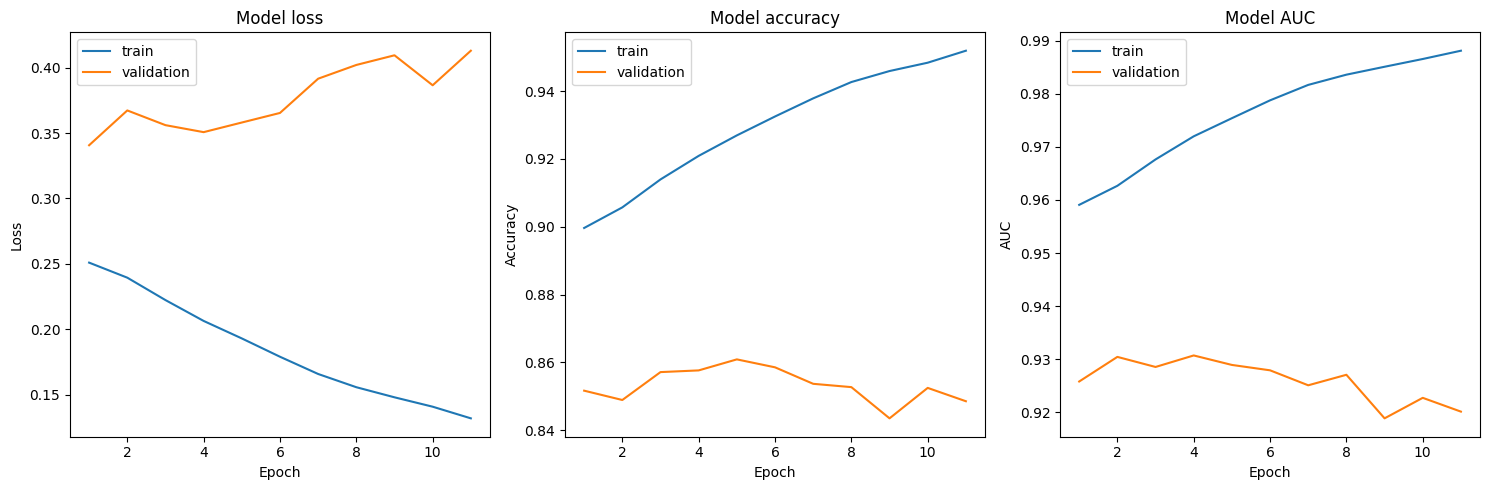

3592/3592 [==============================] - 64s 18ms/step
Best Epoch: 1
Best Model Loss: 0.34065476059913635
Best Model Accuracy: 0.8516759276390076
Best Model AUC: 0.9258265495300293


In [121]:
conv_max_dropout_train_res_32 = train_model(conv_max_dropout_model, train_generator_32, validation_generator_32, test_generator, "./conv_max_dropout_model_32", load_from_file=True)
print(f"Best Epoch: {conv_max_dropout_train_res_32[0]}")
print(f"Best Model Loss: {conv_max_dropout_train_res_32[1]}")
print(f"Best Model Accuracy: {conv_max_dropout_train_res_32[2]}")
print(f"Best Model AUC: {conv_max_dropout_train_res_32[3]}")

This optimization ran for 1 epochs, being ended by early stopping because the validation loss stopped improving after epoch 23, where it had a validation accuracy of 85.2% and an AUC of 0.926. These are very similar results to the previous batch size of 16 and the validation accuracy is still highly variable. Despite this, there is now a more noticeable downward trend in the validation loss despite the variability, meaning that the larger batch size is starting to help.

The test AUC from Kaggle is 0.7708, which is a fair amount lower than the validation AUC of 0.926. However, it's lower than before. I am going to stop here

In [125]:
results_df.loc[len(results_df.index)] = ["Convolutional Dropout Batch 32", conv_max_dropout_train_res_32[1], conv_max_dropout_train_res_32[2], conv_max_dropout_train_res_32[3], 0.7708]

# Results

Below is the final results table comparing each of the created models and summarizing their validation loss, accuracy, and auc along with the test AUC

In [126]:
results_df

Model Name  Validation Loss  Validation Accuracy  \
0                      Full Connected         0.674542             0.596137   
1                       Convolutional         0.345262             0.850835   
2               Convolutional Dropout         0.362436             0.845881   
3  Convolutional Max Dropout Batch 16         0.319962             0.862811   
4      Convolutional Dropout Batch 32         0.340655             0.851676   

   Validation AUC  Test score  
0        0.500000      0.5000  
1        0.925531      0.8026  
2        0.919713      0.7978  
3        0.933777      0.7926  
4        0.925827      0.7708

To better visualize all of these metrics and how they compare for each model, create some bar charts

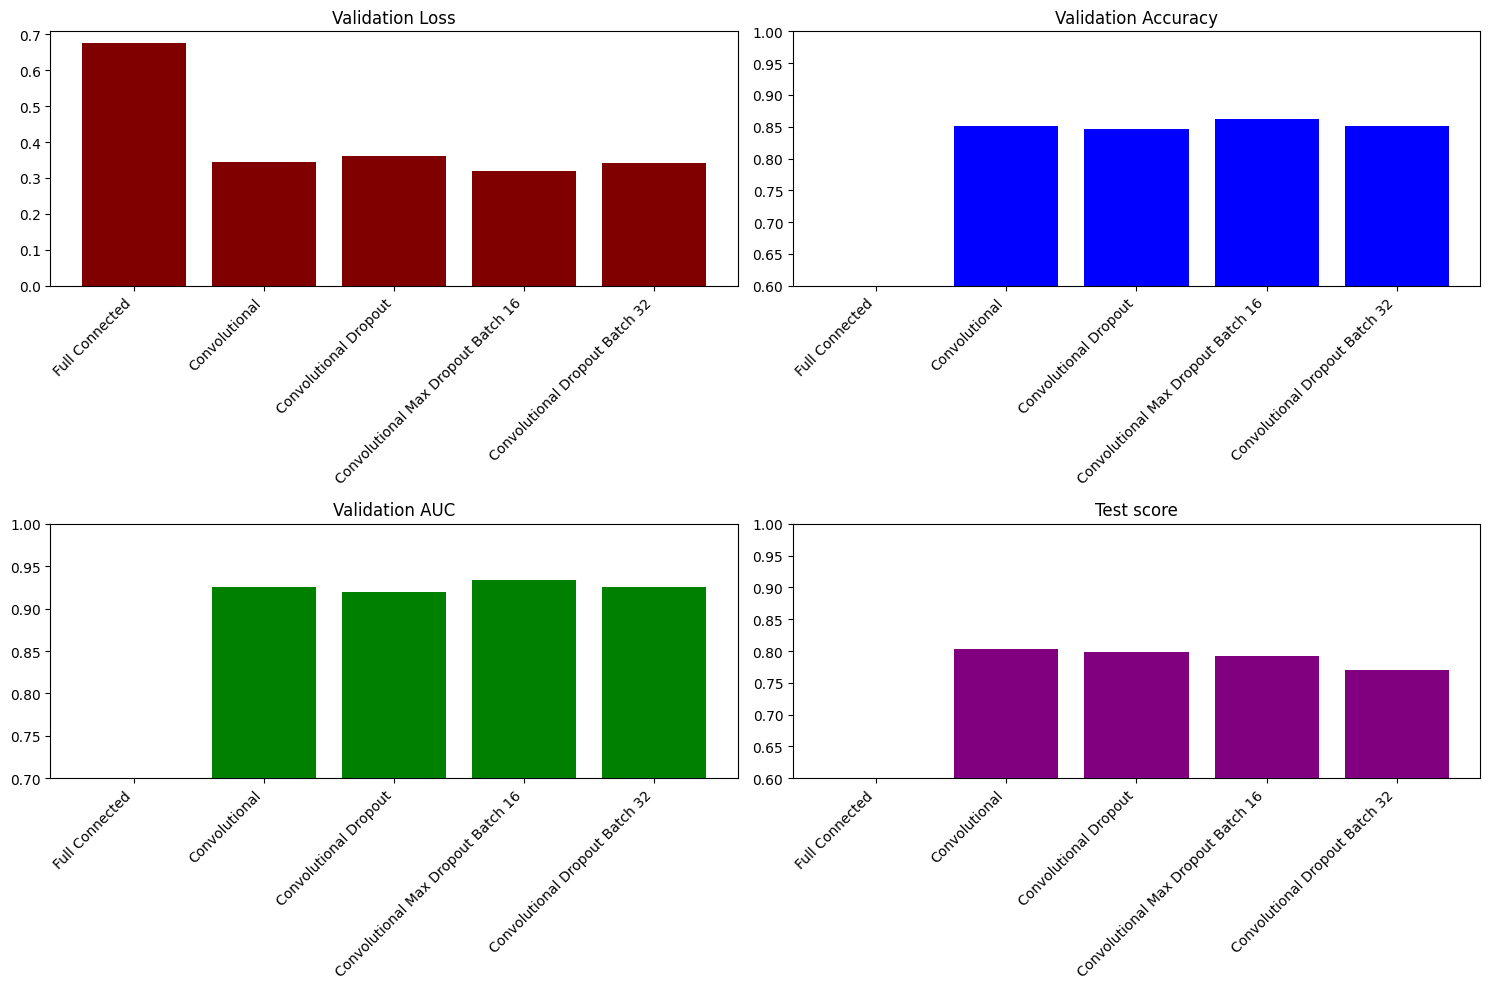

In [129]:
fig, axs = plt.subplots(2, 2, figsize=(15,10))

# Validation Loss bar chart
axs[0, 0].bar(results_df['Model Name'], results_df['Validation Loss'], color ='maroon')
axs[0, 0].set_title('Validation Loss')
axs[0, 0].set_xticks(range(len(results_df['Model Name'])))
axs[0, 0].set_xticklabels(results_df['Model Name'], rotation=45, ha='right')

# Validation Accuracy bar chart
axs[0, 1].bar(results_df['Model Name'], results_df['Validation Accuracy'], color ='blue')
axs[0, 1].set_title('Validation Accuracy')
axs[0, 1].set_xticks(range(len(results_df['Model Name'])))
axs[0, 1].set_xticklabels(results_df['Model Name'], rotation=45, ha='right')
axs[0, 1].set_ylim(0.6, 1)

# Validation AUC bar chart
axs[1, 0].bar(results_df['Model Name'], results_df['Validation AUC'], color ='green')
axs[1, 0].set_title('Validation AUC')
axs[1, 0].set_xticks(range(len(results_df['Model Name'])))
axs[1, 0].set_xticklabels(results_df['Model Name'], rotation=45, ha='right')
axs[1, 0].set_ylim(0.7, 1)

# Test AUC bar chart
axs[1, 1].bar(results_df['Model Name'], results_df['Test score'], color ='purple')
axs[1, 1].set_title('Test score')
axs[1, 1].set_xticks(range(len(results_df['Model Name'])))
axs[1, 1].set_xticklabels(results_df['Model Name'], rotation=45, ha='right')
axs[1, 1].set_ylim(0.6, 1)

plt.tight_layout()
plt.show()

###### Observation about each model based on these results:
* Across all metrics, the full connect model performed the poorest by far. This makes sense since, while not ideal for this task, a dense, fully connected neural network provides a useful baseline against which other models can be evaluated. 
* The most successful convolutional model was the first one without a dropout.
* The convolutional model does not perform better across all measures when dropout is added. It was not the case that the model got better when the batch size hyperparameter was adjusted. Compared to batch size 16, batch size 32 had a little higher loss and AUC.

# Conclusion

Several neural network models were developed for this project to identify malignant or non-cancerous tissue from 96x96 RGB pictures. Initially, a single hidden layer network with high density was trained, but it was not very effective. After that, a straightforward convolutional model was trained

To address this over fitting, the third model added dropout layers to regularize the weights of the model and prevent over fitting, this exposed the issue of highly variable validation metrics. In order to correct the highly variable validation metrics, the hyperparameter of batch size was tuned with values of 32 being tried. The best performing model in the end was the convolutional model with convolutional layer only, which achieved a test score of 0.8.

There are several ways that this model could be extended and improved even further.
The best performing convolutional models still only had two convolutional layers and two fully connected hidden layer. It is likely that by making this neural network even deeper, with more convolutional and max pooling layers, that even more complex features could be found that lead to even better model performance.
